## MET CS677 Data Science with Python - Final Project
### Alan Szmyt
#### Built with Python 3.11.3

In [1]:
!python --version

Python 3.11.3


In [2]:
%%javascript
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$','$'], ['\\(','\\)']],
        processEscapes: true
    },
    tex: {
        packages: {'[+]': ['require']},
    },
});

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from IPython.display import Latex
from utils import (
    create_latex_table,
    data_directory, log, examine_correlation_matrix
)
from dataset.spotify.models import SpotifyColumns, Genre
from pathlib import Path
from main import Dataset
from analyzer import (
    RandomForestAnalytics, RandomForestModel, ClassifierAnalytics,
    ModelAnalyzer, LinearSVMModel, RandomForestAnalyticsCollection,
    LogisticRegressionModel, KNNModel, LinearRegressionModel,
    LinearModelAnalytics, AnalyticsCollection,
)

# Global Seaborn options.
sns.set_theme(font_scale=1.5, style="darkgrid", rc={"text.usetex": True})
pd.set_option("display.precision", 2)
pd.set_option("styler.format.precision", 2)

In [4]:
# Spotify tracks dataset.
dataset_csv: str = "tracks.csv"
tracks_dataset_file: Path = data_directory.joinpath(dataset_csv)

# Load the Spotify tracks dataset from the csv file.
tracks_dataset: Dataset = Dataset.read_csv(
    name="spotify_tracks_dataset",
    filepath_or_buffer=tracks_dataset_file,
    engine="python",
    dtype=SpotifyColumns.dtype(),
)

tracks_dataset = tracks_dataset.drop(
    [SpotifyColumns.NAME, SpotifyColumns.MODE], axis=1
)

# Load the heavy metal tracks into their own dataframe.
heavy_metal_tracks: DataFrame = tracks_dataset.loc[
    tracks_dataset[SpotifyColumns.GENRE].astype(Genre.dtype()) == Genre.METAL
]

# Load the country tracks into their own dataframe.
country_tracks: DataFrame = tracks_dataset.loc[
    tracks_dataset[SpotifyColumns.GENRE].astype(Genre.dtype()) == Genre.COUNTRY
]

In [5]:
tracks_dataset_table: str = create_latex_table(
    tracks_dataset.head().rename(
        columns={
            SpotifyColumns.TIME_SIGNATURE: "time signature"
        }
    ),
    label="tab:tracks_dataset_datatable",
    caption="Spotify Tracks"
)
Latex(tracks_dataset_table)

<IPython.core.display.Latex object>

In [6]:
metal_tracks_table: str = create_latex_table(
    heavy_metal_tracks.head(),
    label="tab:metal_tracks_datatable",
    caption="Spotify Metal Tracks"
)
Latex(metal_tracks_table)

<IPython.core.display.Latex object>

In [7]:
country_tracks_table: str = create_latex_table(
    country_tracks.head(),
    label="tab:country_tracks_datatable",
    caption="Spotify Country Tracks"
)
Latex(country_tracks_table)

<IPython.core.display.Latex object>

In [9]:
# Machine learning model analyzer context class.
analyzer: ModelAnalyzer = ModelAnalyzer(
    dataset=tracks_dataset,
    model=LinearSVMModel(
        category_col=SpotifyColumns.GENRE,
        persistence=True,
        label_transformer=Genre.from_label,
    ),
    category_col=SpotifyColumns.GENRE,
)

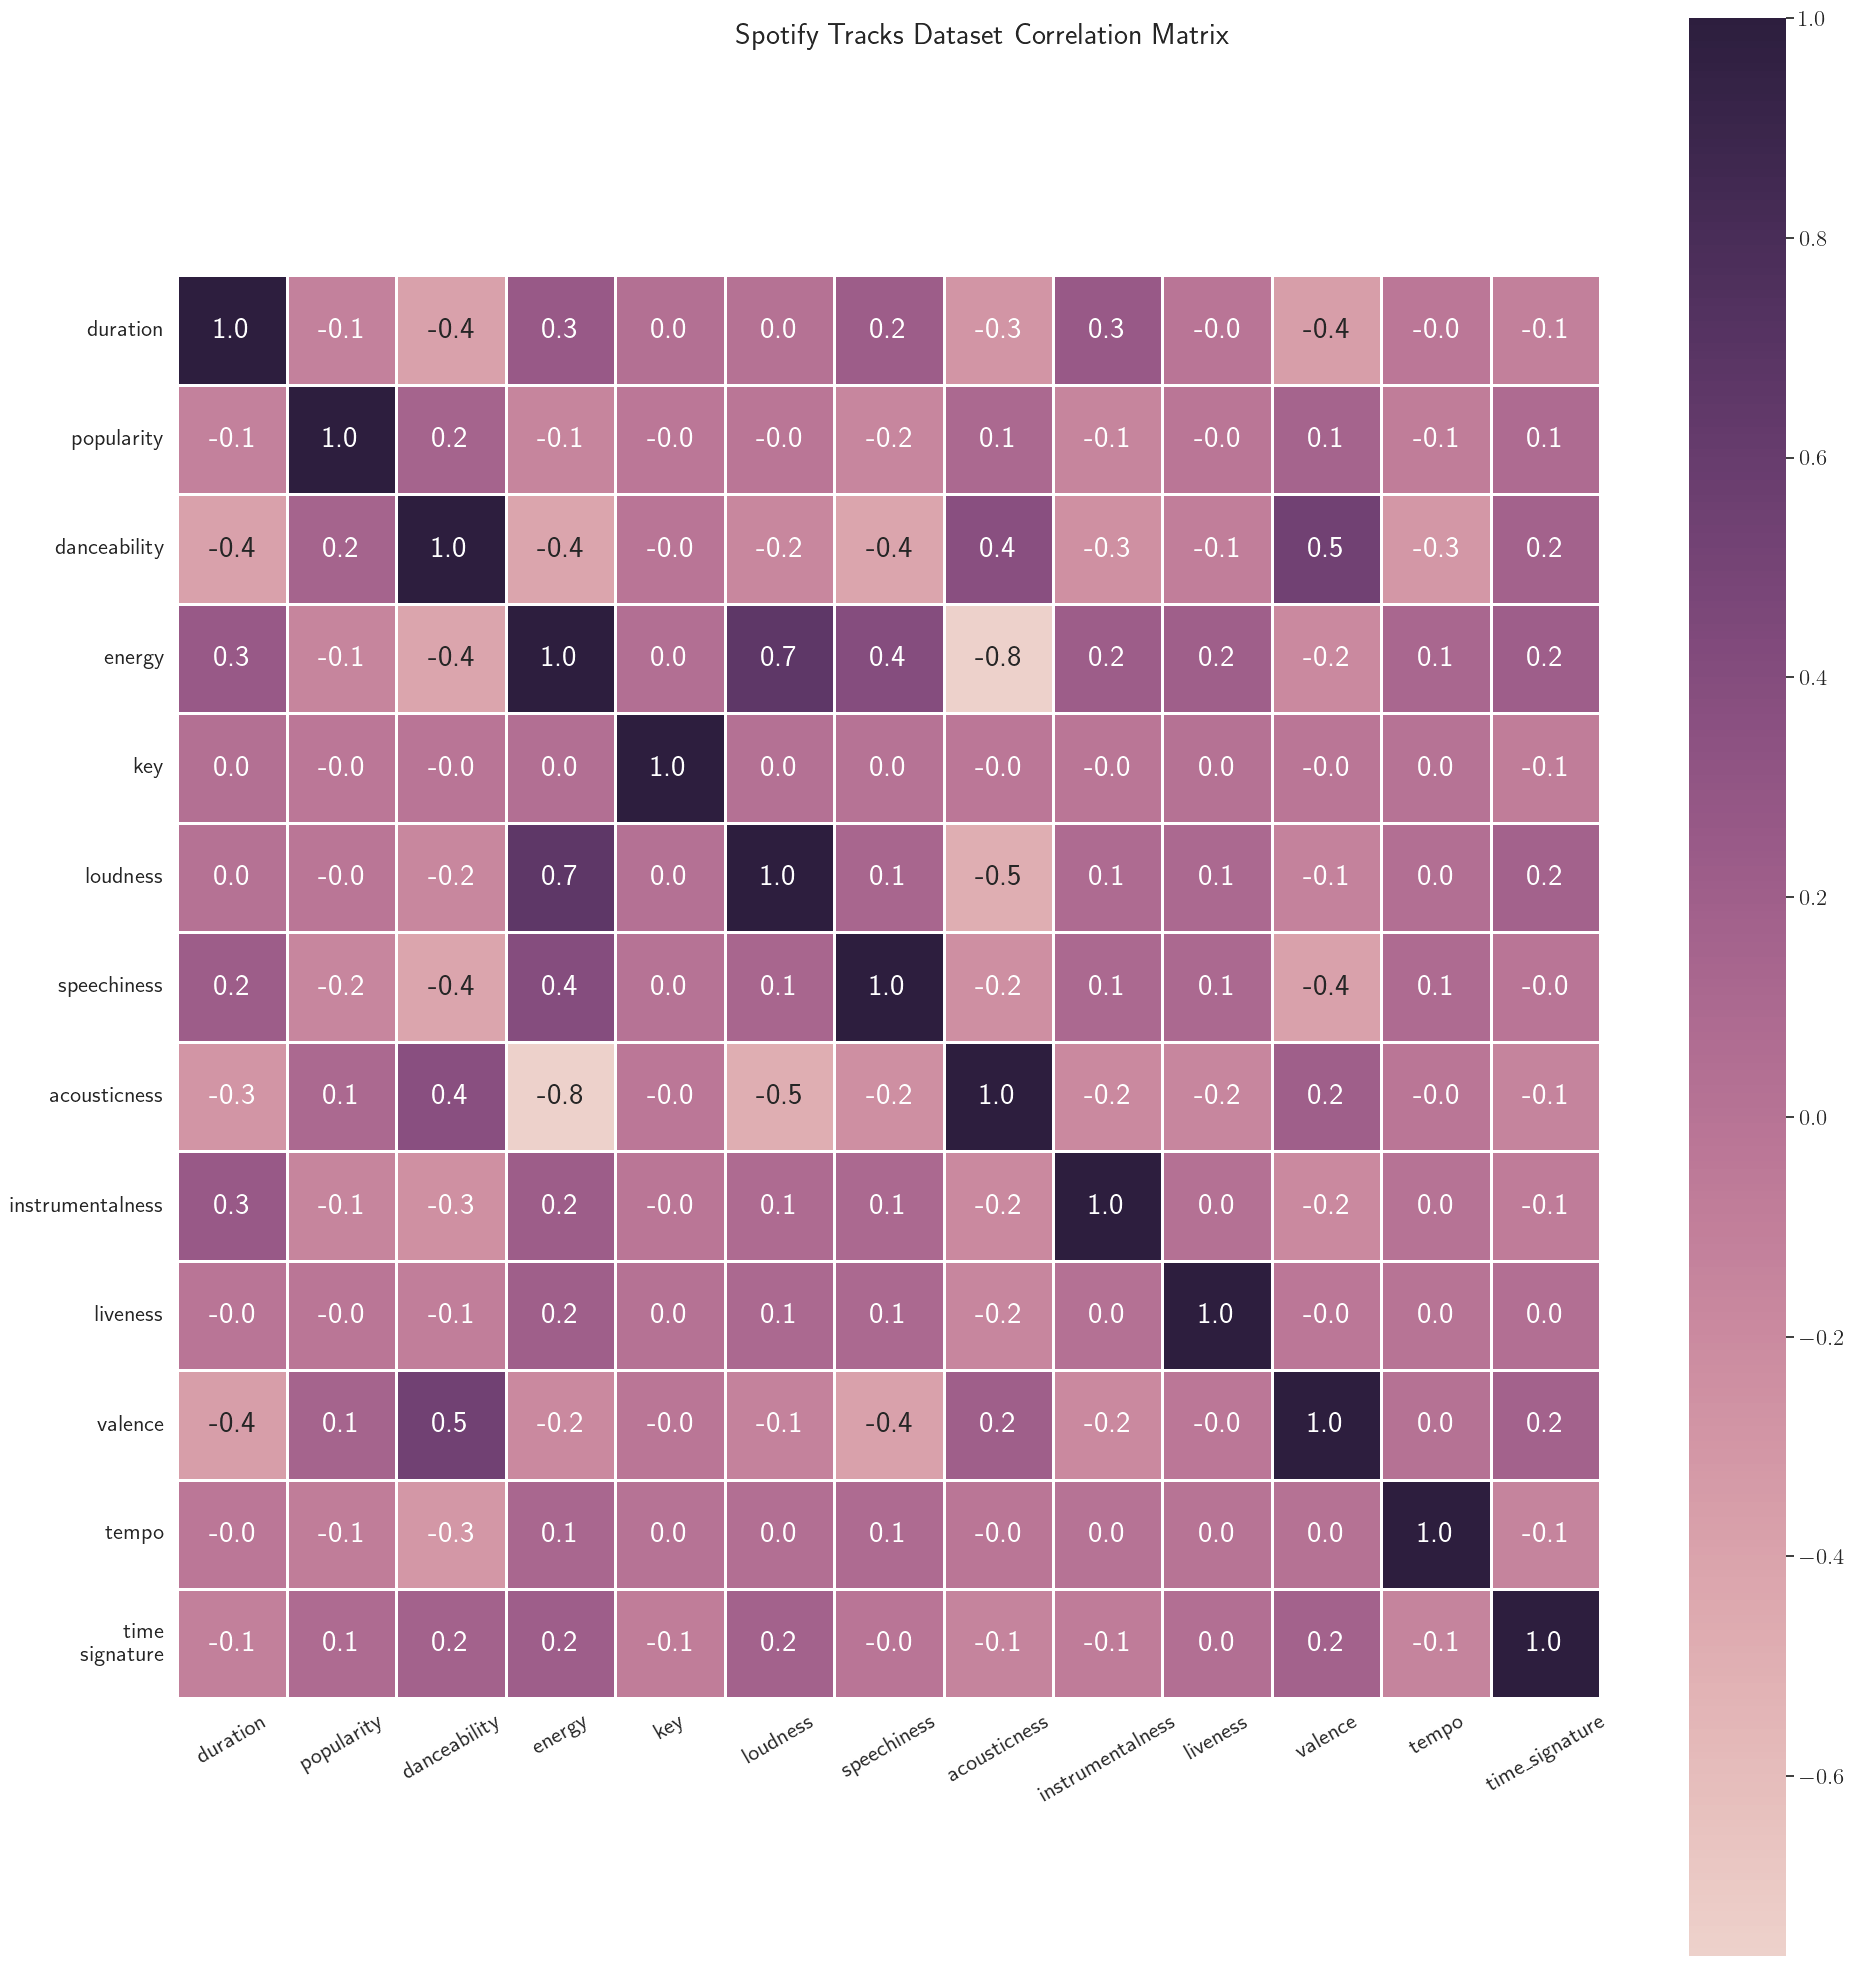

In [10]:
# Plot a correlation matrix between the different music attributes.
correlation_matrix: DataFrame = analyzer.correlation_matrix()

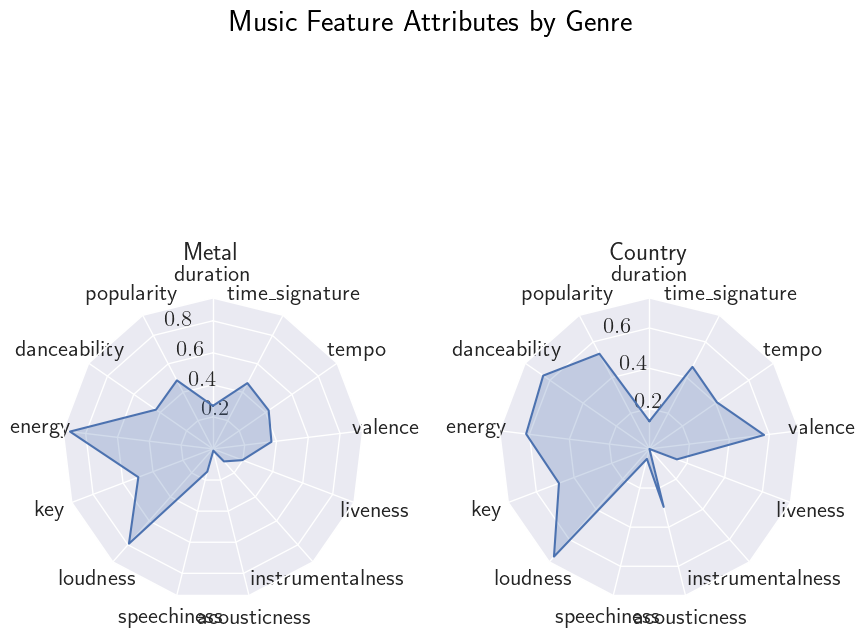

In [11]:
# Plot a radar plot of the music attributes per genre.
analyzer.radar_plot(
    title="Music Feature Attributes by Genre",
    label_transformer=Genre.from_label
)

In [12]:
# Train linear svm model, make predictions, and gather analytics.
linear_svm_analytics: ClassifierAnalytics = analyzer.analyze()

# Compute the accuracy.
print(
    f"Linear kernel SVM accuracy: "
    f"{linear_svm_analytics.confusion_matrix.accuracy.score}"
)

Linear kernel SVM accuracy: 93.78%


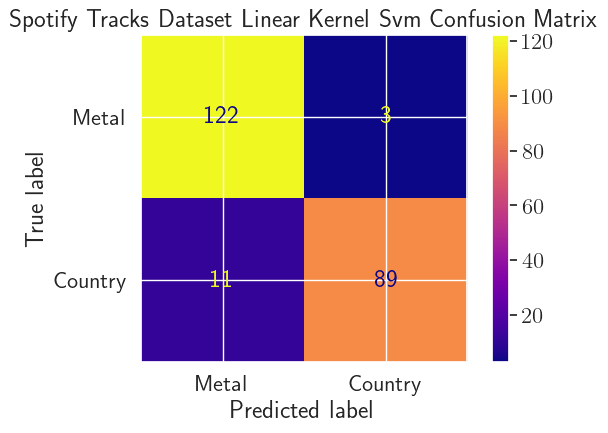

In [13]:
# Compute the confusion matrix.
linear_svm_analytics.show_confusion_matrix()

In [14]:
# Train random forest model, make predictions, and gather analytics.
random_forest_analytics: RandomForestAnalyticsCollection = (
    RandomForestAnalyticsCollection()
)

random_forests: list[RandomForestModel] = [
    RandomForestModel(
        category_col=SpotifyColumns.GENRE,
        persistence=True,
        label_transformer=Genre.from_label,
        trees=n,
        max_depth=d,
    )
    for n in range(1, 11)
    for d in range(1, 6)
]
for random_forest in random_forests:
    analyzer.model = random_forest
    random_forest_analytics.append(analyzer.analyze())

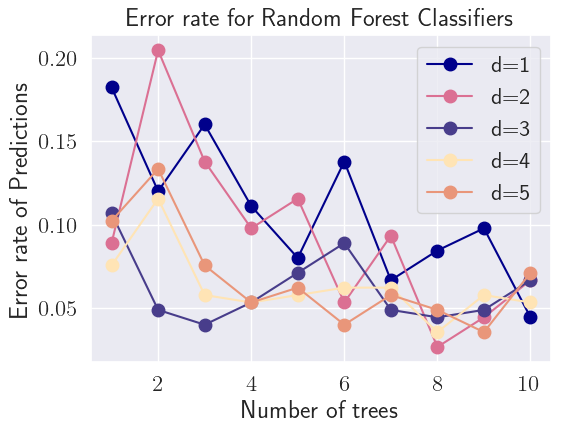

In [15]:
# Error plot for all random forest classifiers.
random_forest_analytics.show_error_plot()

In [16]:
# Get the random forest with the lowest error rate.
best_random_forest: RandomForestAnalytics = random_forest_analytics.lowest_error
print(
    f"Best combination of N and d is: "
    f"N={best_random_forest.trees}, "
    f"d={best_random_forest.max_depth}"
)

print(
    f"The accuracy for best random forest is: "
    f"{best_random_forest.confusion_matrix.accuracy.score}"
)

Best combination of N and d is: N=8, d=2
The accuracy for best random forest is: 97.33%


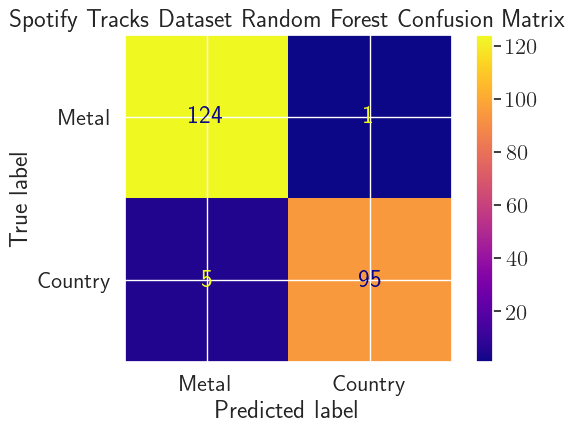

In [17]:
# Compute the confusion matrix.
best_random_forest.show_confusion_matrix()

In [18]:
# Train logistic regression model, make predictions, and gather analytics.
analyzer.model = LogisticRegressionModel(
    category_col=SpotifyColumns.GENRE,
    persistence=True,
    label_transformer=Genre.from_label,
)
logistic_regression_analytics: ClassifierAnalytics = analyzer.analyze()

# Compute the accuracy.
print(
    f"Logistic regression classifier accuracy: "
    f"{logistic_regression_analytics.confusion_matrix.accuracy.score}"
)

Logistic regression classifier accuracy: 70.67%


In [19]:
# Train kNN model, make predictions, and gather analytics.
analyzer.model = KNNModel(
    category_col=SpotifyColumns.GENRE,
    persistence=True,
    label_transformer=Genre.from_label,
)
knn_analytics: ClassifierAnalytics = analyzer.analyze()

# Compute the accuracy.
print(
    f"kNN classifier accuracy: "
    f"{knn_analytics.confusion_matrix.accuracy.score}"
)

kNN classifier accuracy: 90.22%


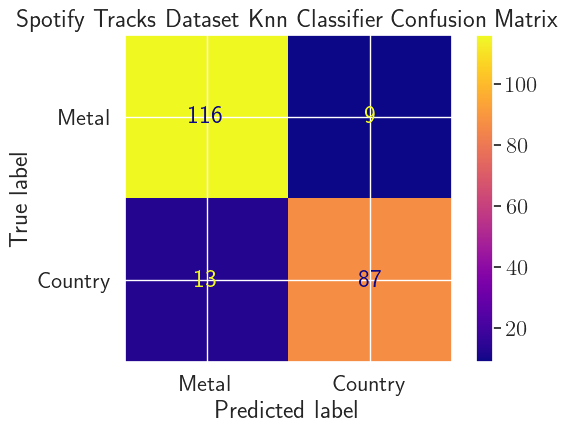

In [20]:
# Compute the confusion matrix.
knn_analytics.show_confusion_matrix()

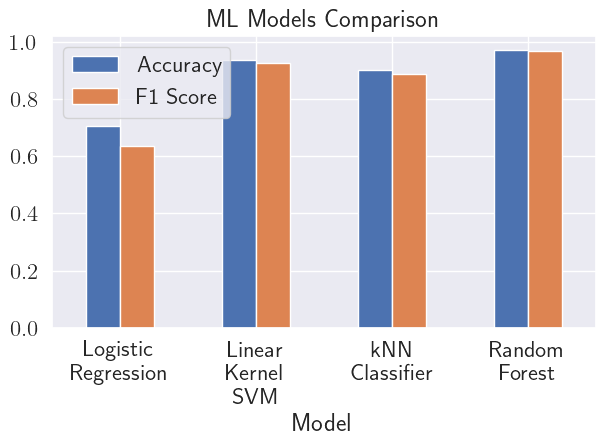

In [21]:
# Gather analytics for all classifier models.
classifier_analytics: AnalyticsCollection = AnalyticsCollection(
    [
        logistic_regression_analytics,
        linear_svm_analytics,
        knn_analytics,
        best_random_forest,
    ]
)

classifier_analytics.plot()

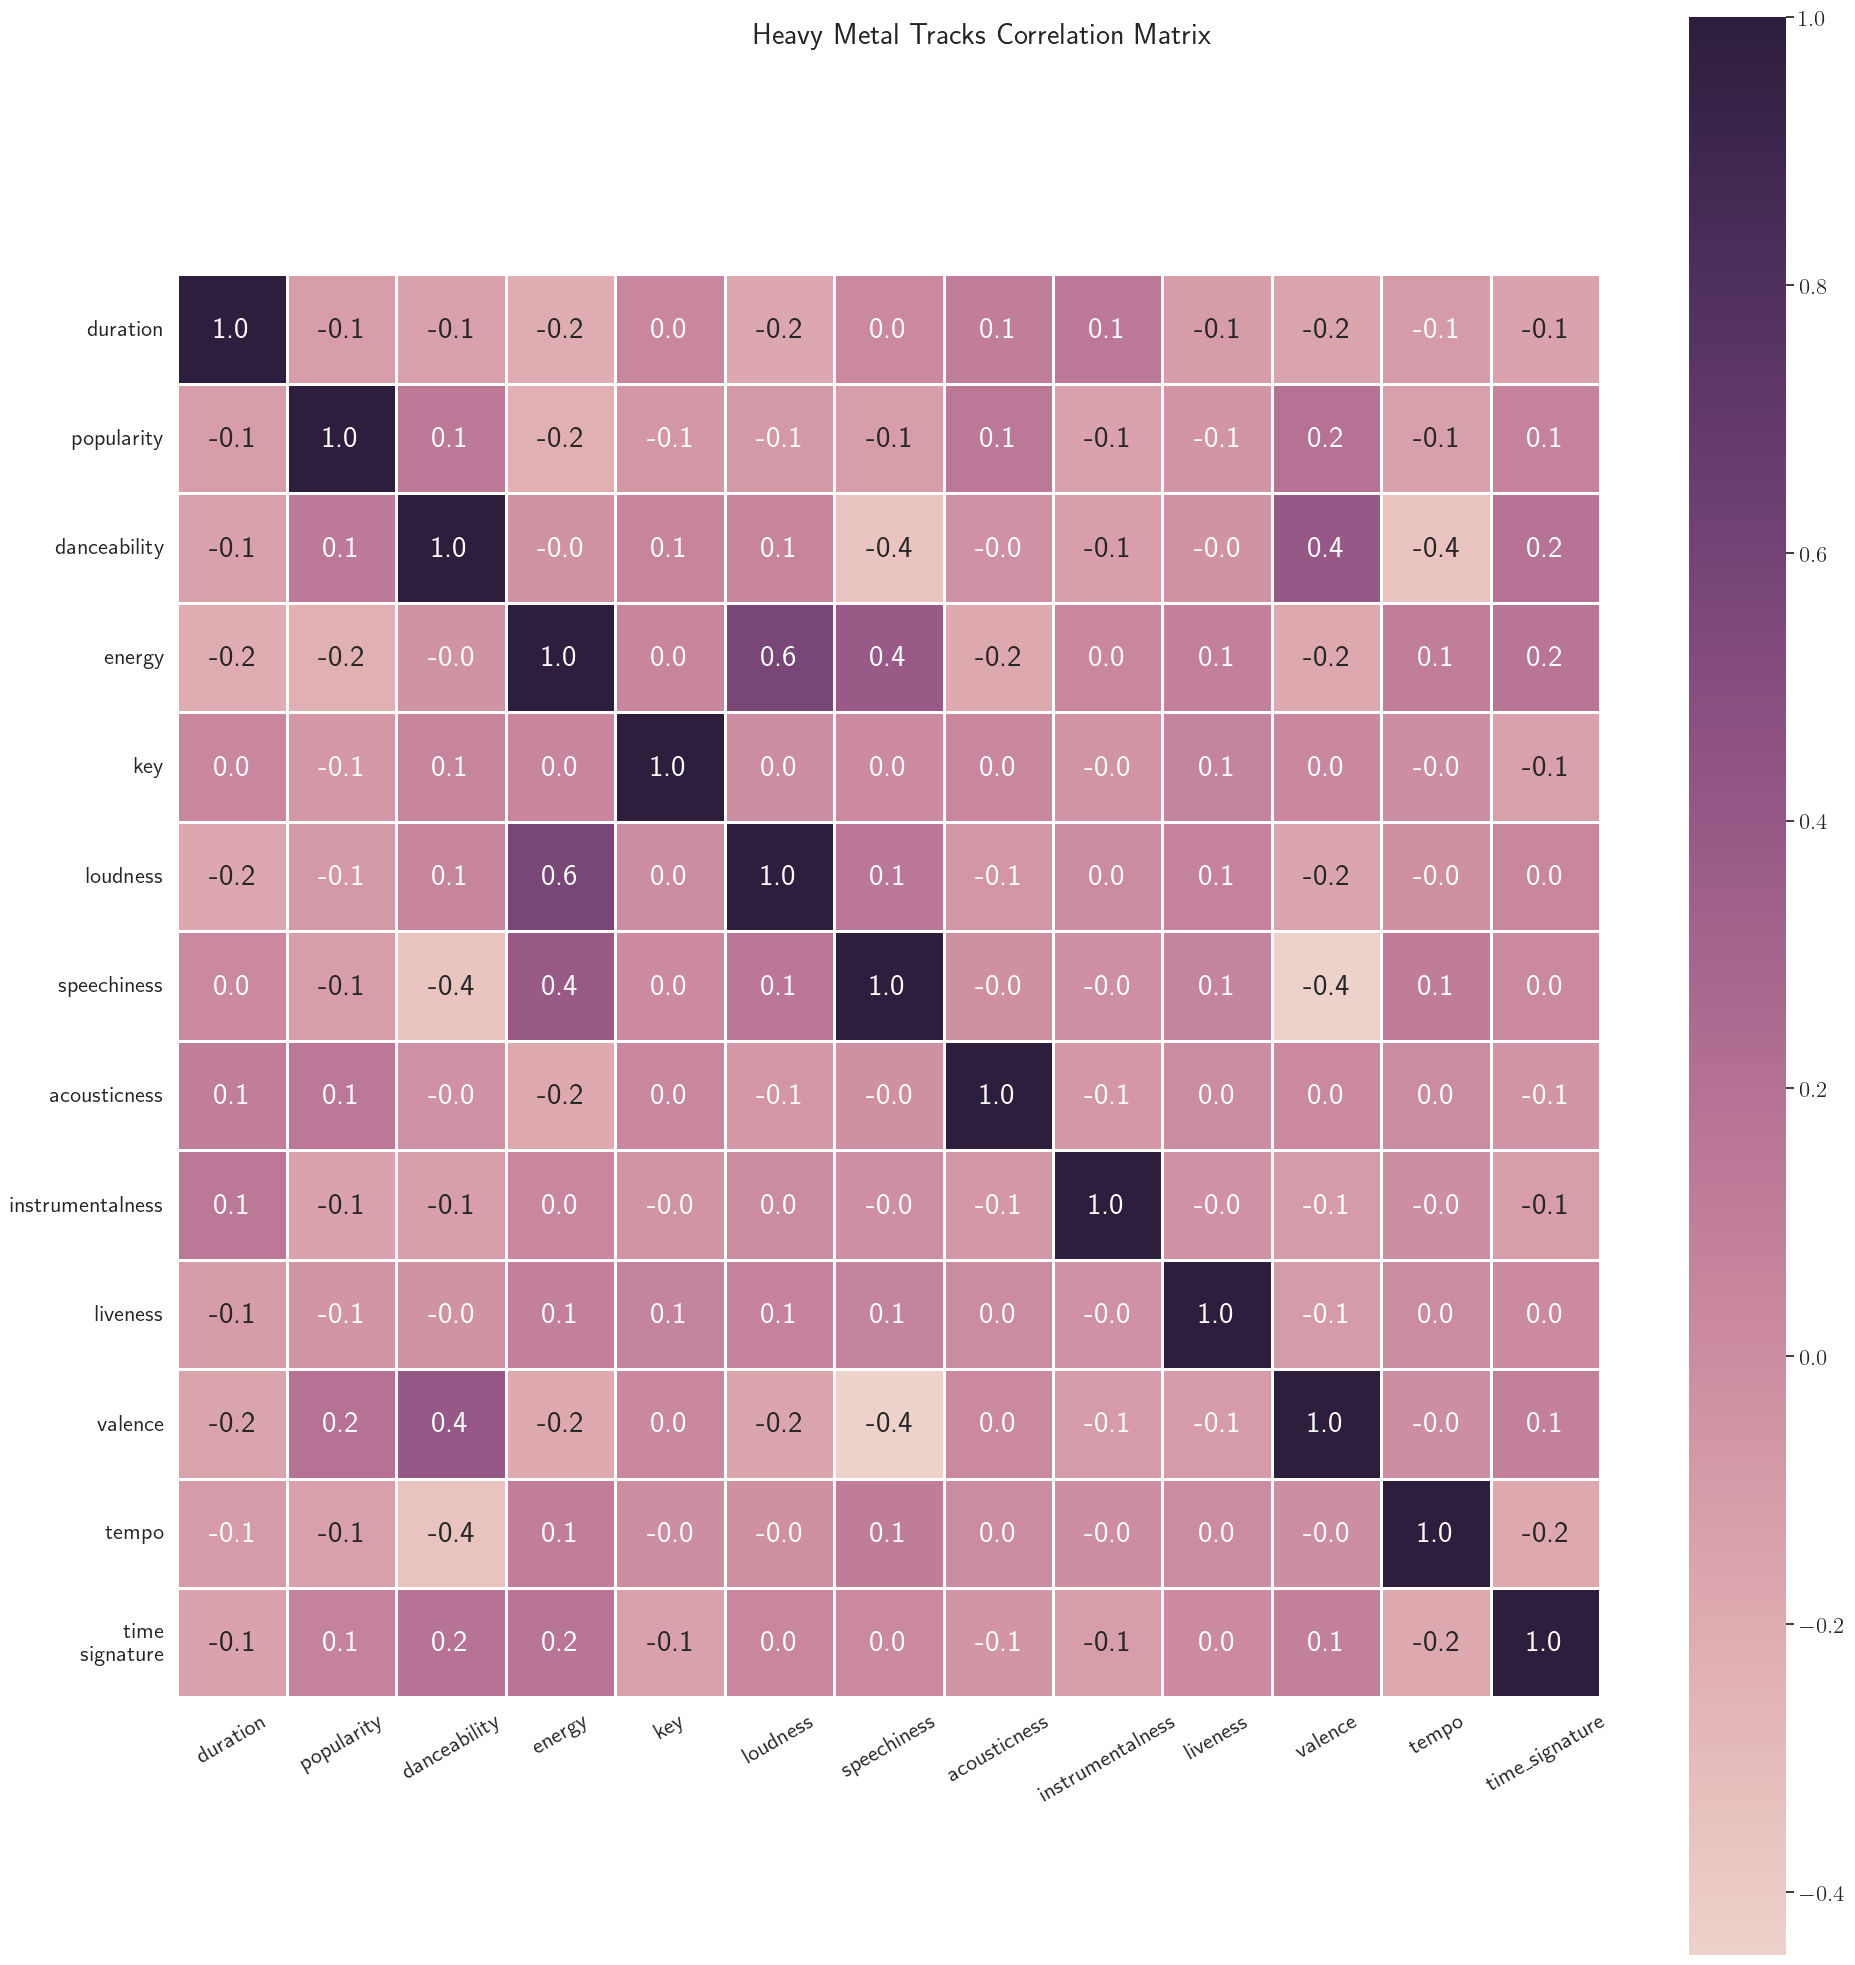

In [22]:
# Plot a correlation matrix for heavy metal tracks.
metal_correlation_matrix = ModelAnalyzer.create_correlation_matrix(
    dataset=heavy_metal_tracks.drop(SpotifyColumns.GENRE, axis=1),
    title="Heavy Metal Tracks Correlation Matrix"
)

In [24]:
# Examine the heavy metal tracks' correlation matrix.
metal_correlations = examine_correlation_matrix(metal_correlation_matrix)

# Get the highest correlated features.
mhc_features = list(metal_correlations.head(1).to_dict().items())[0]

# Train linear regression model, make predictions, and gather analytics.
analyzer.dataset = heavy_metal_tracks
analyzer.model = LinearRegressionModel(
    category_col=SpotifyColumns.GENRE,
    predictor_col=SpotifyColumns.from_column(mhc_features[0][0]),
    response_col=SpotifyColumns.from_column(mhc_features[0][1]),
    persistence=True,
    label_transformer=Genre.from_label,
    degree=3,
)
linear_regression_analytics: LinearModelAnalytics = analyzer.analyze()

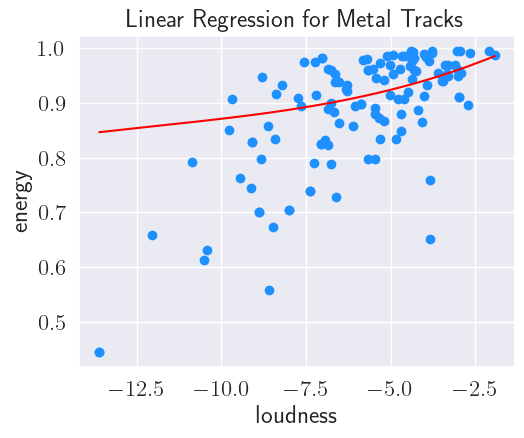

In [25]:
linear_regression_analytics.plot(title="Linear Regression for Metal Tracks")

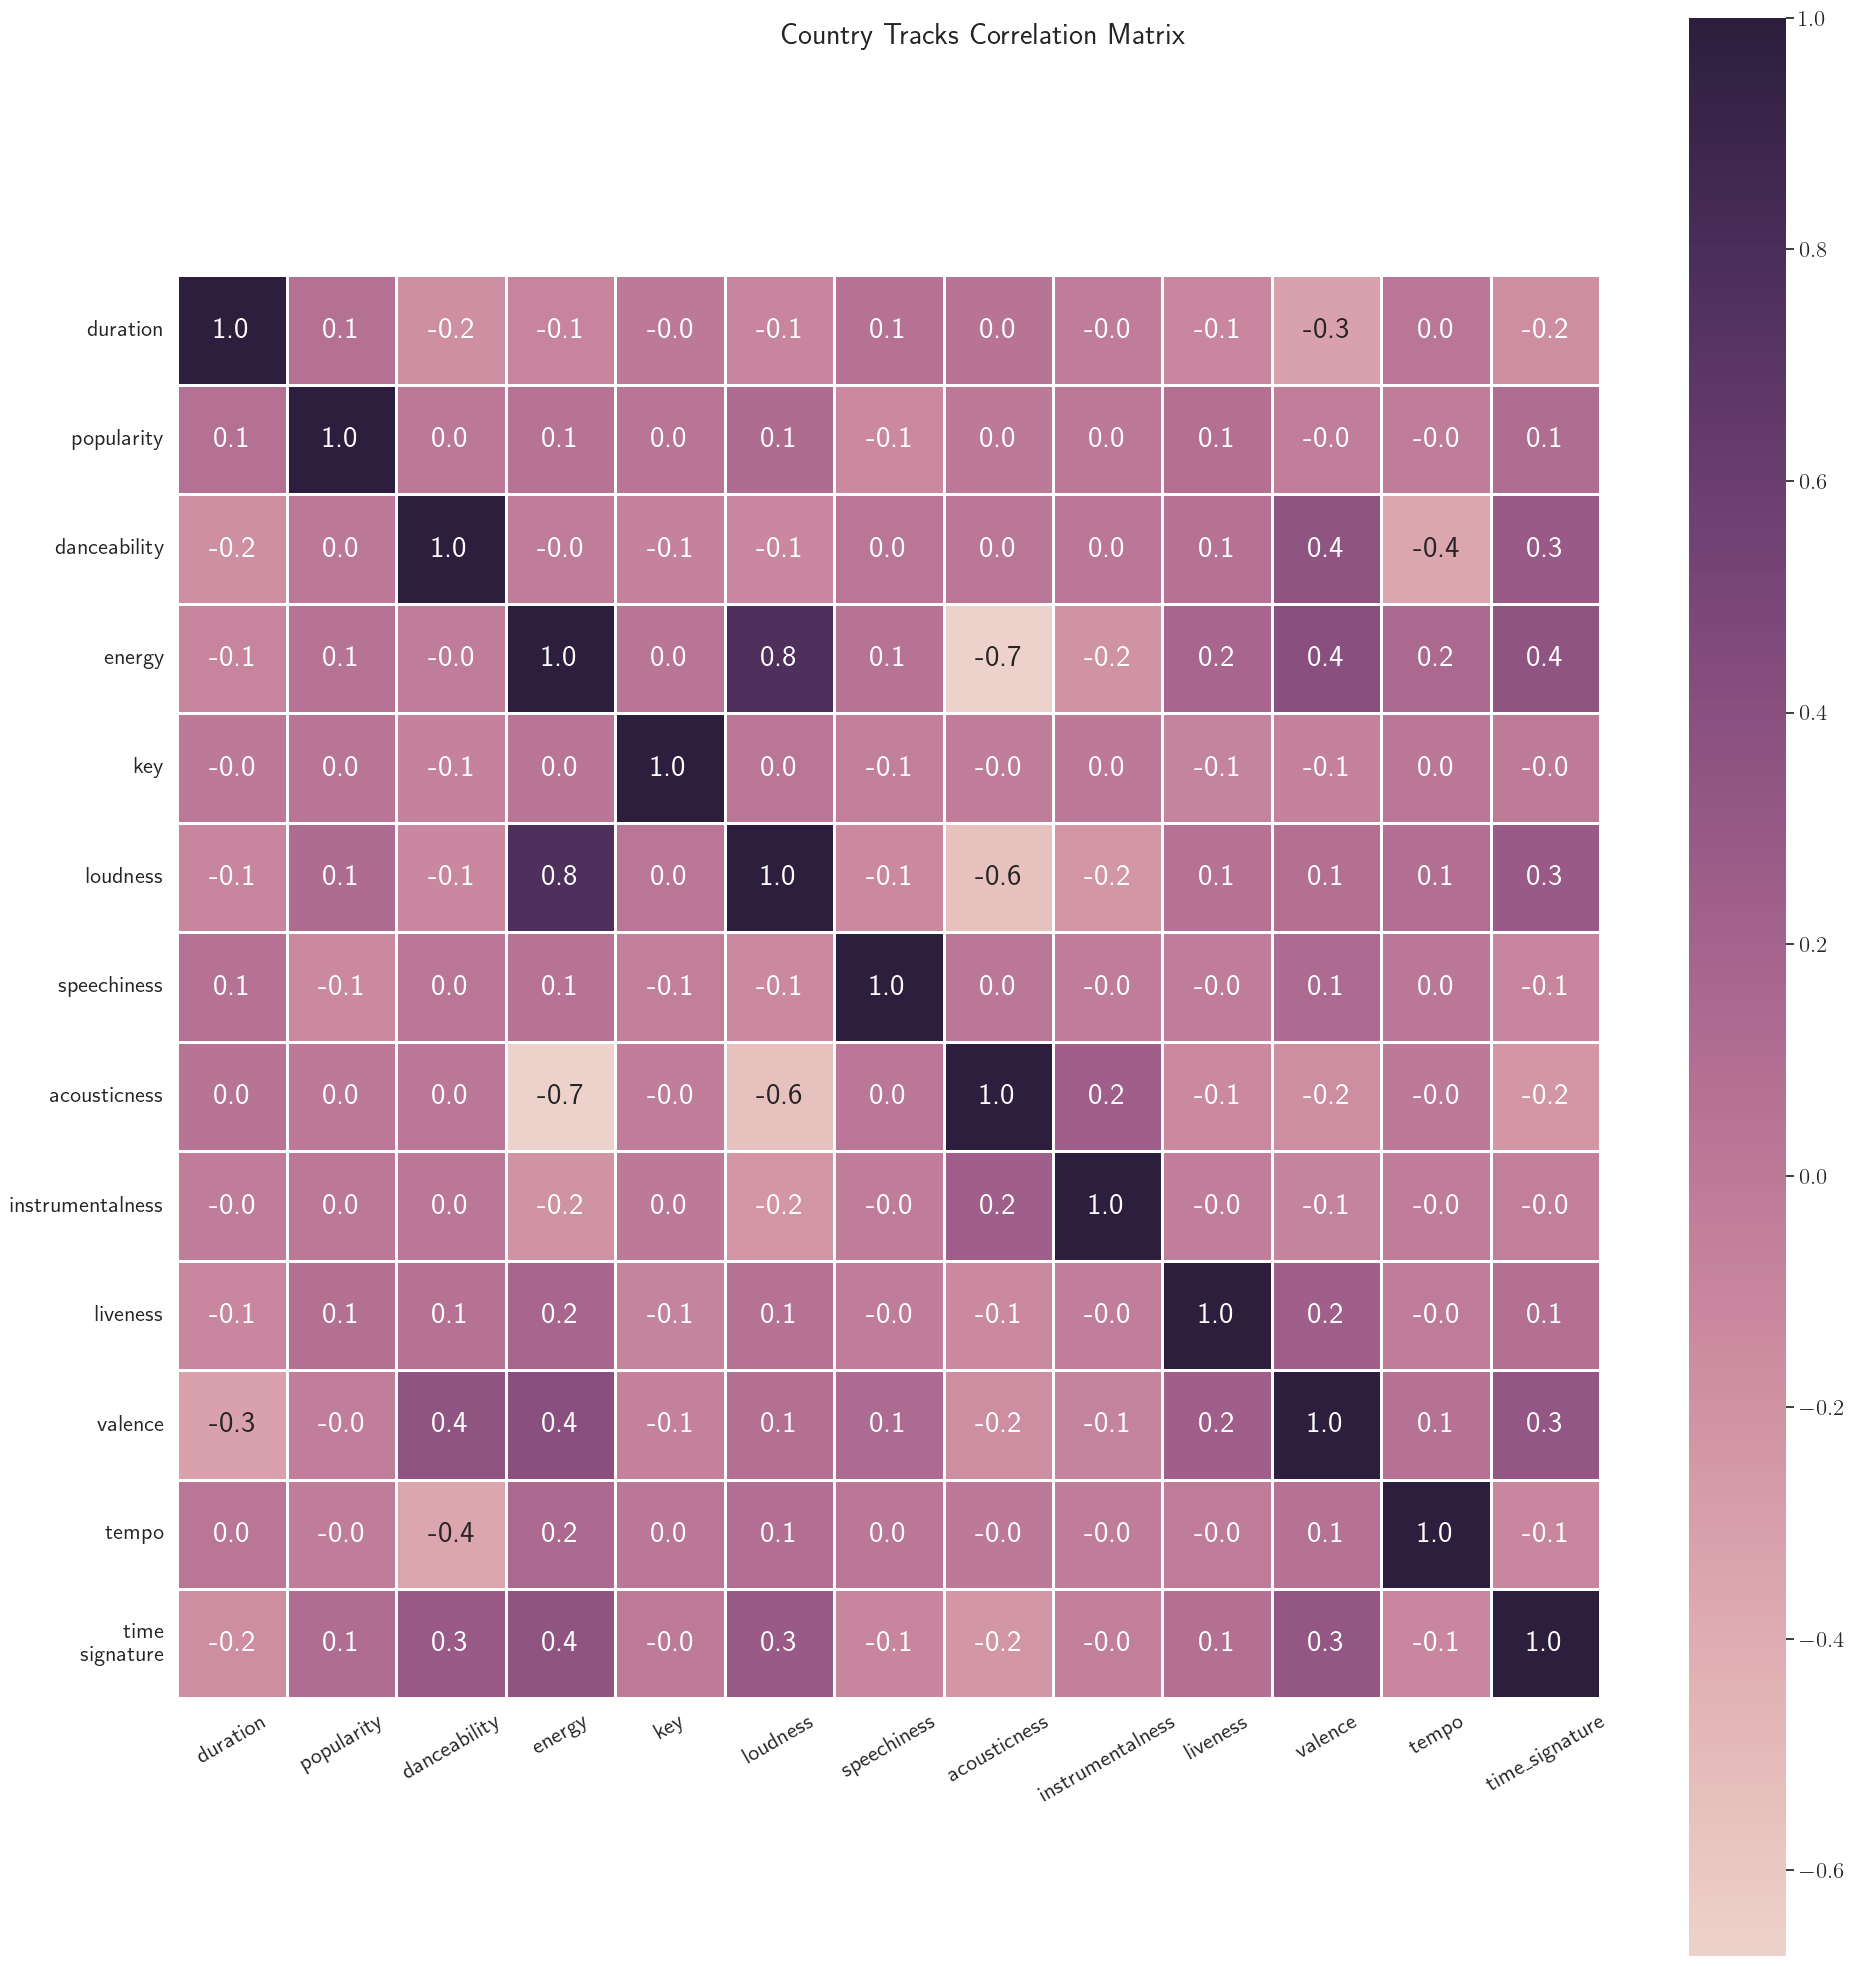

In [26]:
# Plot a correlation matrix for heavy metal tracks.
country_correlation_matrix = ModelAnalyzer.create_correlation_matrix(
    dataset=country_tracks.drop(SpotifyColumns.GENRE, axis=1),
    title="Country Tracks Correlation Matrix"
)

In [27]:
# Examine the country tracks' correlation matrix.
country_correlations = examine_correlation_matrix(country_correlation_matrix)

# Get the highest correlated features.
chc_features = list(country_correlations.head(1).to_dict().items())[0]

# Train linear regression model, make predictions, and gather analytics.
analyzer.dataset = country_tracks
analyzer.model = LinearRegressionModel(
    category_col=SpotifyColumns.GENRE,
    predictor_col=SpotifyColumns.from_column(chc_features[0][0]),
    response_col=SpotifyColumns.from_column(chc_features[0][1]),
    persistence=True,
    label_transformer=Genre.from_label,
    degree=3,
)
linear_regression_analytics: LinearModelAnalytics = analyzer.analyze()

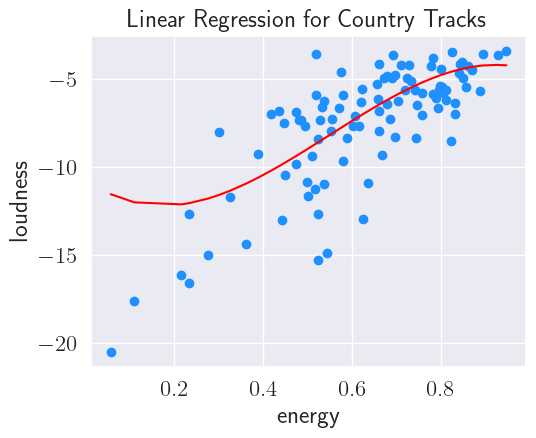

In [28]:
linear_regression_analytics.plot(title="Linear Regression for Country Tracks")

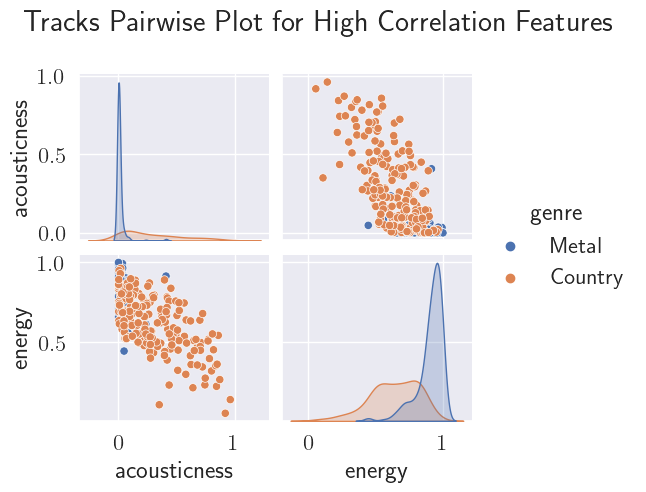

In [29]:
# Examine the tracks' correlation matrix.
track_correlations = examine_correlation_matrix(correlation_matrix)

# Get the highest correlated features.
hc_features = list(track_correlations.head(1).to_dict().items())[0]

# Train linear regression model, make predictions, and gather analytics.
hc_predictor_col = SpotifyColumns.from_column(hc_features[0][0])
hc_response_col = SpotifyColumns.from_column(hc_features[0][1])

# Create pairwise plot for tracks with high correlation features.
ModelAnalyzer.create_pairwise_plot(
    dataset=tracks_dataset[
        [hc_predictor_col, hc_response_col, SpotifyColumns.GENRE]
    ],
    category_col=SpotifyColumns.GENRE,
    title="Tracks Pairwise Plot for High Correlation Features",
    label_transformer=Genre.from_label_to_title
)

In [30]:
summary_table: str = create_latex_table(
    classifier_analytics.summary_table,
    label="tab:summary_datatable",
    caption="Classifier Summary"
)
Latex(summary_table)

<IPython.core.display.Latex object>